In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph, piecewise_extraction

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import utils

In [3]:
param_file = 'CaBP_param.json'
param_file = Path('../0_data/manual').resolve().joinpath(param_file)

In [4]:
# Model training is param #3 (network is 1, hyperparmas is 2)
out_dir = utils.read_data_param(param_file)[2]

In [5]:
tgt_edge, tgt_node = utils.load_targets(param_file)

In [6]:
nodes, edges = utils.load_network(param_file)

In [8]:
best_param, features = utils.load_hyperparameters(param_file)

In [9]:
len(features)

368

In [10]:
print('{:,} Nodes'.format(len(nodes)))
print('{:,} Edges'.format(len(edges)))

250,035 Nodes
9,652,116 Edges


In [11]:
best_param

{'C': 0.0014351562349983393,
 'l1_ratio': 0.9871439566131671,
 'w': 0.5665616931869023}

## Routine for extracting information

In [13]:
%%time
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', tgt_node, max_length=4, w=best_param['w'], n_jobs=32)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:54<00:00,  1.25it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:26<00:00,  2.56it/s]



Weighting matrices by degree with dampening factor 0.5665616931869023...


100%|██████████| 68/68 [00:00<00:00, 128.39it/s]


CPU times: user 42 s, sys: 14.1 s, total: 56.1 s
Wall time: 2min 17s


In [15]:
# Ensure that we have float64 matrices"
mg.degree_weighted_matrices[tgt_edge.split('_')[-1]]

<40766x21065 sparse matrix of type '<class 'numpy.float64'>'
	with 38936 stored elements in Compressed Sparse Column format>

#### Right away lets get the true positives as we will need them later

In [16]:
pos_tups = (mg.edge_df.query('type == @tgt_edge')[['start_id', 'end_id']]
                      .apply(tuple, axis=1)
                      .tolist())
pos_tups = set(pos_tups)

In [17]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()

In [19]:
neg_frac = 0.1
rs = 20201117

tgt_comps = set(edges.query('type == @tgt_edge')['start_id'])
# Sample the negatives and subsample, but not Reframe negatvies... keep them as 'Unknown'
keep_comps = set(nodes.query('id not in @tgt_comps and id not in @ref_c and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id'])
# Merge togetehr
keep_comps = sorted(list(keep_comps | tgt_comps))

# Get our target type 
tgt_endp = set(edges.query('type == @tgt_edge')['end_id'])
# Sample the negatives and subsample cv
keep_endp = set(nodes.query('label == @tgt_node and id not in @tgt_endp')
                    .sample(frac=neg_frac, random_state=rs+1)['id'])
# Merge together
keep_endp = sorted(list(keep_endp | tgt_endp))

In [23]:
print(len(keep_comps), len(keep_endp))
print('{:,}'.format(len(keep_comps) * len(keep_endp)))
print('{:,}'.format(len(keep_comps) * len(keep_endp) * len(features)))

9203 4879
44,901,437
16,523,728,816


In [24]:
def display_time(seconds):
    result = []
    
    intervals = (
    ('weeks', 604800),  # 60 * 60 * 24 * 7
    ('days', 86400),    # 60 * 60 * 24
    ('hours', 3600),    # 60 * 60
    ('minutes', 60),
    ('seconds', 1),
    )


    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{:1.0f} {}".format(value, name))
    return ', '.join(result)

In [26]:
from data_tools.ml import get_model_coefs, MeanScaledArcsinhTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

In [27]:
enet_params = {k: v for k, v in best_param.items() if k != 'w'}

post_extraction_pipeline = Pipeline(
    [('transformer', MeanScaledArcsinhTransformer()),
     ('maxabs_scale', MaxAbsScaler()),
     ('e_net', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000,
                                  random_state=rs+11, **enet_params))], verbose=True)

In [ ]:
%%time

start = time()

(pairs, out_mp), dwpc = mg.extract_dwpc(metapaths=features, start_nodes=keep_comps, end_nodes=keep_endp, 
                   return_sparse=True, sparse_df=False, verbose=True, n_jobs=30)

In [ ]:
print('Getting Target Values')
y = []
for row in tqdm(pairs.itertuples(), total=len(pairs)):
    # pos_tups defined several cells above
    if set([(row.chemicalsubstance_id, getattr(row, tgt_node.lower()+'_id'))]) & pos_tups:
        y.append(1)
    else:
        y.append(0)

y = np.array(y)
pairs['status'] = y

print('Getting training subset')
# subset so that we're training only with nonzero dwpc rows
# Get the training examples that have metapaths
nz_index = pairs[dwpc.getnnz(1)>0].index
# have the number of postivies to get 100x this for the negatives.
n_pos = pairs['status'].sum()
# Sample the nonzero negative examples at a rate of 100x the positive samples
neg_index = pairs.loc[nz_index].query('status == 0').sample(n=100*n_pos, random_state=rs+10).sort_index().index
# and of course take the training postivies
pos_index = pairs.query('status == 1').index
# Union the two
train_index = pos_index.union(neg_index)

# Fit the model and get results
print('Training Model')
post_extraction_pipeline.fit(dwpc[train_index, :], y[train_index])

In [32]:
# Get coef
print('Getting Model Coef')
trans_dwpc = post_extraction_pipeline[1].transform(post_extraction_pipeline[0].transform(dwpc[train_index, :]))

coef = get_model_coefs(post_extraction_pipeline[-1], trans_dwpc, features).sort_values('coef', ascending=False)

print('Training took: ' + display_time(time() - start))
print('\n\n')

Getting Model Coef
Training took: 1 hour, 2 minutes, 34 seconds





In [34]:
utils.save_model(post_extraction_pipeline, out_mp, coef, out_dir)

In [35]:
coef.head(10)

,feature,coef,zcoef
274,CafGpoPWawCaBP,5.11754,0.610519
276,CafGpoPWawCinBP,1.56342,0.186322
133,CinBPpoGrxCaBP,1.34645,0.0980447
102,CafBPpoGrxCinBP,0.914266,0.0738776
208,CaGpoPWawCaBP,0.797664,0.0954112
275,CafGpoPWawCafBP,0.532689,0.0640926
88,CaBPpoPWawCaBP,0.395829,0.0343998
150,CinBPpoPWawCaBP,0.394653,0.0311148
16,CafBPpoCafBP,0.359196,0.0180484
343,CawPWpoGnrCinBP,0.333242,0.0254332


In [36]:
len(coef.query('coef != 0')) - 1

25

In [37]:
%%time

start = time()
        
# Fit the model and get results
print('Getting Probabilities')
y_proba = post_extraction_pipeline.predict_proba(dwpc)[:, 1]

Getting Probabilities
CPU times: user 5min 26s, sys: 1min 12s, total: 6min 39s
Wall time: 6min 39s


In [38]:
# Get metrics
print('Metrics on training data')
roc_auc = roc_auc_score(y, y_proba)
avg_prec = average_precision_score(y, y_proba)
print('AUROC: {:1.4f}'.format(roc_auc))
print('AUPR: {:1.4f}'.format(avg_prec))

Metrics on training data
AUROC: 0.9472
AUPR: 0.1731


In [39]:
pairs['status'] = y
pairs['proba'] = y_proba

# Save results
pairs.to_csv(out_dir.joinpath('results.csv'), index=False)

print('Eval took: ' + display_time(time() - start))
print('\n\n')

Eval took: 9 minutes, 15 seconds





## Load back in all the results and plot

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

from data_tools import plotting as pt

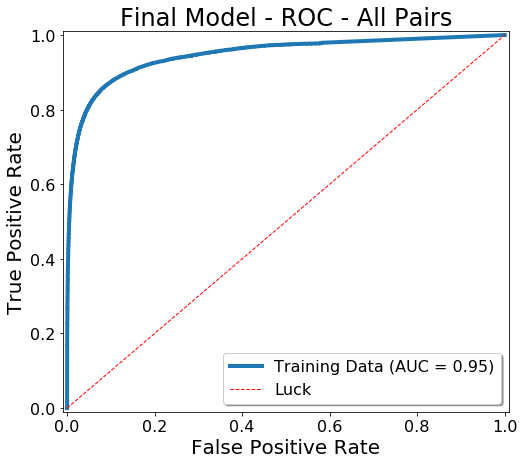

In [41]:
pt.graph_single_roc(y, y_proba, 'Training Data')
pt.graph_roc_boilerplate('Final Model - ROC - All Pairs');

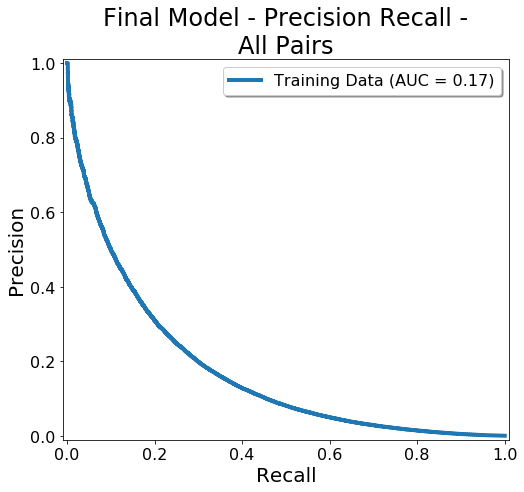

In [42]:
pt.graph_single_prc(y, y_proba, 'Training Data')
pt.graph_prc_boilerplate('Final Model - Precision Recall -\nAll Pairs');

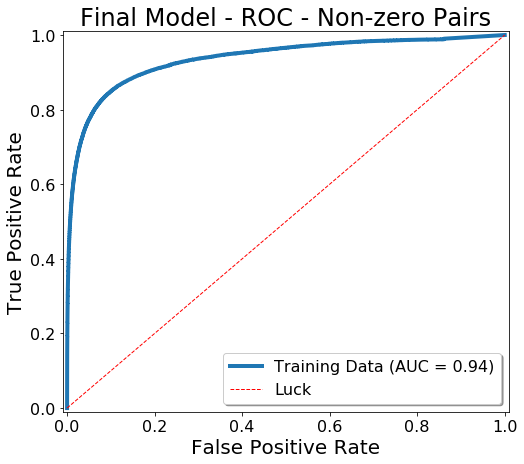

In [43]:
pt.graph_single_roc(y[nz_index], y_proba[nz_index], 'Training Data')
pt.graph_roc_boilerplate('Final Model - ROC - Non-zero Pairs');

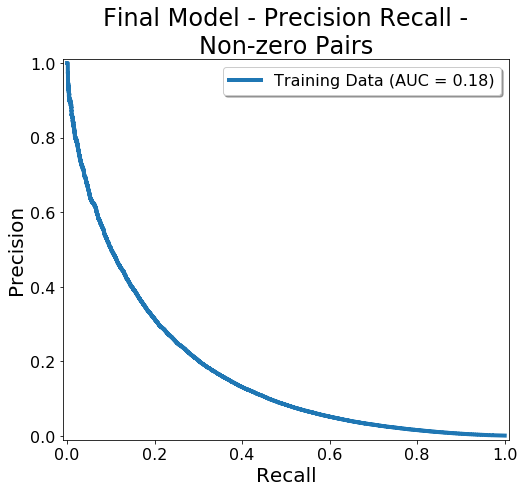

In [44]:
pt.graph_single_prc(y[nz_index], y_proba[nz_index], 'Training Data')
pt.graph_prc_boilerplate('Final Model - Precision Recall -\nNon-zero Pairs');

In [48]:
id_to_name = nodes.set_index('id')['name'].to_dict()
pairs['chem'] = pairs['chemicalsubstance_id'].map(id_to_name)
pairs['bp'] = pairs['biologicalprocessoractivity_id'].map(id_to_name)

In [49]:
pairs.head(10)

,chemicalsubstance_id,biologicalprocessoractivity_id,status,proba,chem,bp
0,CHEBI:100148,GO:0000002,0,0.001238,"1,1,1-propanetricarboxylic acid",mitochondrial genome maintenance
1,CHEBI:100148,GO:0000003,0,0.001238,"1,1,1-propanetricarboxylic acid",Reproduction
2,CHEBI:100148,GO:0000025,0,0.001238,"1,1,1-propanetricarboxylic acid",maltose catabolic process
3,CHEBI:100148,GO:0000026,0,0.001238,"1,1,1-propanetricarboxylic acid","alpha-1,2-mannosyltransferase activity"
4,CHEBI:100148,GO:0000035,0,0.001238,"1,1,1-propanetricarboxylic acid",acyl binding
5,CHEBI:100148,GO:0000041,0,0.001238,"1,1,1-propanetricarboxylic acid",transition metal ion transport
6,CHEBI:100148,GO:0000042,0,0.001238,"1,1,1-propanetricarboxylic acid",protein targeting to Golgi
7,CHEBI:100148,GO:0000045,0,0.001238,"1,1,1-propanetricarboxylic acid",autophagosome assembly
8,CHEBI:100148,GO:0000050,0,0.001238,"1,1,1-propanetricarboxylic acid",urea cycle
9,CHEBI:100148,GO:0000070,0,0.001238,"1,1,1-propanetricarboxylic acid",mitotic sister chromatid segregation


In [50]:
pairs = pairs.sort_values('proba', ascending=False)

In [51]:
pairs.head(50)

,chemicalsubstance_id,biologicalprocessoractivity_id,status,proba,chem,bp
9017152,CHEBI:33216,GO:0006915,1,0.993302,bisphenol A,apoptotic process
9017319,CHEBI:33216,GO:0008283,1,0.991926,bisphenol A,cellular proliferation
9017313,CHEBI:33216,GO:0008219,1,0.990835,bisphenol A,cell death
7343655,CHEBI:29678,GO:0006915,1,0.989855,sodium arsenite,apoptotic process
12159228,CHEBI:45713,GO:0006915,1,0.988615,trans-resveratrol,apoptotic process
44360628,UNII:OHF2F5C0ZH,GO:0006915,1,0.988461,Tetrachlorodibenzodioxin,apoptotic process
11407862,CHEBI:39867,GO:0006915,1,0.987405,valproic acid,apoptotic process
44360795,UNII:OHF2F5C0ZH,GO:0008283,1,0.986801,Tetrachlorodibenzodioxin,cellular proliferation
7187527,CHEBI:29081,GO:0006915,1,0.986741,synephrine,apoptotic process
7397324,CHEBI:29865,GO:0006915,1,0.986368,benzo[a]pyrene,apoptotic process


In [52]:
pairs.query('status == 0').head(50)

,chemicalsubstance_id,biologicalprocessoractivity_id,status,proba,chem,bp
9017312,CHEBI:33216,GO:0008217,0,0.976839,bisphenol A,regulation of blood pressure
9017006,CHEBI:33216,GO:0006309,0,0.974985,bisphenol A,apoptotic DNA fragmentation
9018689,CHEBI:33216,GO:0042310,0,0.974199,bisphenol A,vasoconstriction
44361181,UNII:OHF2F5C0ZH,GO:0016042,0,0.972704,Tetrachlorodibenzodioxin,lipid catabolic process
9018690,CHEBI:33216,GO:0042311,0,0.972572,bisphenol A,vasodilation
20019464,CHEBI:78510,GO:0008283,0,0.972220,dorsomorphin,cellular proliferation
7397756,CHEBI:29865,GO:0010942,0,0.968868,benzo[a]pyrene,positive regulation of cell death
11408415,CHEBI:39867,GO:0016042,0,0.968681,valproic acid,lipid catabolic process
9017966,CHEBI:33216,GO:0030154,0,0.968188,bisphenol A,cell differentiation
3723990,CHEBI:16469,GO:0016042,0,0.965270,17beta-estradiol,lipid catabolic process


In [53]:
pairs.query('status == 0').drop_duplicates(subset=['chemicalsubstance_id']).head(50)

,chemicalsubstance_id,biologicalprocessoractivity_id,status,proba,chem,bp
9017312,CHEBI:33216,GO:0008217,0,0.976839,bisphenol A,regulation of blood pressure
44361181,UNII:OHF2F5C0ZH,GO:0016042,0,0.972704,Tetrachlorodibenzodioxin,lipid catabolic process
20019464,CHEBI:78510,GO:0008283,0,0.972220,dorsomorphin,cellular proliferation
7397756,CHEBI:29865,GO:0010942,0,0.968868,benzo[a]pyrene,positive regulation of cell death
11408415,CHEBI:39867,GO:0016042,0,0.968681,valproic acid,lipid catabolic process
3723990,CHEBI:16469,GO:0016042,0,0.965270,17beta-estradiol,lipid catabolic process
17277466,CHEBI:6809,GO:0008283,0,0.965069,methamphetamine,cellular proliferation
33129170,MESH:C023035,GO:0006915,0,0.964417,"3,4,5,3',4'-pentachlorobiphenyl",apoptotic process
41297048,MESH:D004041,GO:0010942,0,0.963710,Dietary Fats,positive regulation of cell death
3391826,CHEBI:15930,GO:0008219,0,0.963265,atrazine,cell death


In [54]:
pairs.query('status == 0').drop_duplicates(subset=['biologicalprocessoractivity_id']).head(50)

,chemicalsubstance_id,biologicalprocessoractivity_id,status,proba,chem,bp
9017312,CHEBI:33216,GO:0008217,0,0.976839,bisphenol A,regulation of blood pressure
9017006,CHEBI:33216,GO:0006309,0,0.974985,bisphenol A,apoptotic DNA fragmentation
9018689,CHEBI:33216,GO:0042310,0,0.974199,bisphenol A,vasoconstriction
44361181,UNII:OHF2F5C0ZH,GO:0016042,0,0.972704,Tetrachlorodibenzodioxin,lipid catabolic process
9018690,CHEBI:33216,GO:0042311,0,0.972572,bisphenol A,vasodilation
20019464,CHEBI:78510,GO:0008283,0,0.972220,dorsomorphin,cellular proliferation
7397756,CHEBI:29865,GO:0010942,0,0.968868,benzo[a]pyrene,positive regulation of cell death
9017966,CHEBI:33216,GO:0030154,0,0.968188,bisphenol A,cell differentiation
33129170,MESH:C023035,GO:0006915,0,0.964417,"3,4,5,3',4'-pentachlorobiphenyl",apoptotic process
11408030,CHEBI:39867,GO:0008284,0,0.963909,valproic acid,positive regulation of cell proliferation
